# Environment Setup

In [ ]:
#Pretty standard stuff here

!mkdir PongReinforcementLearning
!cd PongReinforcementLearning

# Then, I set up a virtual environment (venv)
python -m venv PongReinforcementLearningVENV
!source PongReinforcementLearningVENV/bin/activate

# Make the venv recognizable to Jupyter Notebooks.
# This is the bridge that connects Jupyter to my isolated Python environment.
%pip install ipyconfig
python -m ipykernel install --user --name=PongReinforcementLearningVENV

# Time to fire up Jupyter Notebook.
# Make sure to select the new venv as the Python interpreter.
jupyter notebook

# Finally, installing some libs, i usually do these via the console but Jupyter's % operator usually works just fine
%pip3 install pygame
%pip install numpy
%pip install pandas
%pip install tabulate
%pip install torch torchvision
%pip install matplotlib

# Pong

In [ ]:
import pygame
import random
import numpy as np  
import pickle
import os
import math
import logging
import datetime
import torch
import torch.nn as nn
import torch.optim as optim

#class QNetwork(nn.Module):
#    def __init__(self, input_dim, output_dim):
#        super(QNetwork, self).__init__()
#        self.fc1 = nn.Linear(input_dim, 256)
#        self.fc2 = nn.Linear(256, 128)
#        self.fc3 = nn.Linear(128, 64)
#        self.fc4 = nn.Linear(64, output_dim)
#
#    def forward(self, x):
#        x = torch.relu(self.fc1(x))
#        x = torch.relu(self.fc2(x))
#        x = torch.relu(self.fc3(x))
#        return self.fc4(x)
    
#class QNetwork(nn.Module):
#    def __init__(self, input_dim, output_dim):
#        super(QNetwork, self).__init__()
#        self.fc1 = nn.Linear(input_dim, 128)
#        self.fc2 = nn.Linear(128, 64)
#        self.fc3 = nn.Linear(64, output_dim)
#
#    def forward(self, x):
#        x = torch.relu(self.fc1(x))
#        x = torch.relu(self.fc2(x))
#        return self.fc3(x)

class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


#Convert input coordinate to discrete grid space.  this smaller grid space should make learning easier.
def discretize_grid(coordinate, game_board_grid_size): 
    return coordinate // game_board_grid_size

def discretize_paddle_step(coordinate, paddle_step_size): 
    return coordinate // paddle_step_size

#Convert velocity into discretized space (of only 4 options!)
def discretize_velocity(velocity_x, velocity_y):
    if velocity_x > 0 and velocity_y > 0:
        return 0  # Up-Right
    elif velocity_x > 0 and velocity_y < 0:
        return 1  # Down-Right
    elif velocity_x < 0 and velocity_y > 0:
        return 2  # Up-Left
    elif velocity_x < 0 and velocity_y < 0:
        return 3  # Down-Left
    
#Main Pong game function, accepts key parameters as inputs now
def play_de_game(episodes_to_run, update_screen, alpha, gamma, epsilon, epsilon_min, epsilon_decay, game_board_grid_size, paddle_step_size, reward_for_winning_episode, punishment_for_losing_episode, reward_for_hitting_ball, width, height, backpropagation_state_buffer_size):
    
    #Instanciate our Neural Nets + Optimizers
    left_agent_model = QNetwork(input_dim=4, output_dim=3)
    right_agent_model = QNetwork(input_dim=4, output_dim=3)
    left_optimizer = optim.Adam(left_agent_model.parameters(), lr=0.001)
    right_optimizer = optim.Adam(right_agent_model.parameters(), lr=0.001)
    
    # Calculate loss and update neural networks
    loss_fn = nn.MSELoss()
    
    # Initialize buffers for left and right agents
    #backpropagation_state_buffer_size = 2 * (height // paddle_step_size)  # number of decisions to move paddle from top to bottom of screen, times a multiplier
    #backpropagation_state_buffer_size = 25
    backpropagation_state_buffer_left = []
    backpropagation_state_buffer_right = []
    
    #Key Results
    KR_reward_events_left = 0
    KR_reward_events_right = 0
    KR_ball_hits_left = 0
    KR_ball_hits_right = 0
    KR_max_episode_length = 0
    KR_avg_episode_length_every_100_episodes = {}

    # Initialize scores
    left_score = 0
    right_score = 0
    
    # Initial paddle positions
    left_paddle_pos = [50, height // 2 - paddle_height // 2]
    right_paddle_pos = [width - 50 - paddle_width, height // 2 - paddle_height // 2]
    # Paddle positions to a random spot
    #left_paddle_pos = [50, random.randint(0, height - paddle_height)]
    #right_paddle_pos = [width - 50 - paddle_width, random.randint(0, height - paddle_height)]
    
    # Initial Ball position and velocity
    ball_pos = [width // 2, height // 2]
    ball_velocity = [random.choice([-4, 4]), random.choice([-4, 4])]
    
    # Initialize episode metrics
    episode_count = 0
    this_episode_length = 0
    last_100_episode_lengths = []
    
    # Init whether each AI agent has hit the ball in this episode yet
    contact_with_ball_made_this_episode_left = False
    contact_with_ball_made_this_episode_right = False
    
    # Create the state representation for both agents, this captures the state at the end of the previous loop
    state_left = (0, 0, 0, 0)
    state_right = (0, 0, 0, 0)
    action_left = 0
    action_right = 0
    
    # Init results
    results = {}
    
    run = True
    user_quit = False
    while run:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                run = False
                user_quit = True
                
        #pygame.time.delay(100)
        
        # Create the state representation for both agents, this captures the state at the end of the previous loop
        #state_left = (discretize_paddle_step(left_paddle_pos[1], paddle_step_size), discretize_grid(ball_pos[0], game_board_grid_size), discretize_grid(ball_pos[1], game_board_grid_size), discretize_velocity(ball_velocity[0], ball_velocity[1]), action_left)
        #state_right = (discretize_paddle_step(right_paddle_pos[1], paddle_step_size), discretize_grid(ball_pos[0], game_board_grid_size), discretize_grid(ball_pos[1], game_board_grid_size), discretize_velocity(ball_velocity[0], ball_velocity[1]), action_right)

        #Track game loops in this episode/game and report to screen to get a sense of how many loops a game lasts
        this_episode_length += 1

        #Debug track whether we have a rewarded event in this loop
        reward_left_applied_this_loop = False
        reward_right_applied_this_loop = False

        # Reset rewards to 0 at the beginning of each pass through the game loop
        reward_left = 0
        reward_right = 0

        # Update the backpropagation buffers
        #if len(backpropagation_state_buffer_left) >= backpropagation_state_buffer_size: # If we're at the size limit
        #    backpropagation_state_buffer_left.pop(0)  # Remove the oldest left state
        #backpropagation_state_buffer_left.append(state_left)  # Add the current left state
        #if len(backpropagation_state_buffer_right) >= backpropagation_state_buffer_size: # If we're at the size limit
        #    backpropagation_state_buffer_right.pop(0)  # Remove the oldest right state
        #backpropagation_state_buffer_right.append(state_right)  # Add the current right state
        
        # Convert states to tensors
        state_left_tensor = torch.FloatTensor([state_left])
        state_right_tensor = torch.FloatTensor([state_right])

        # Get Q-values from neural networks
        with torch.no_grad():
            q_values_left = left_agent_model(state_left_tensor)
            q_values_right = right_agent_model(state_right_tensor)

        # Choose actions using epsilon-greedy policy
        action_left = torch.argmax(q_values_left).item() if np.random.rand() >= epsilon else np.random.choice(action_space)
        action_right = torch.argmax(q_values_right).item() if np.random.rand() >= epsilon else np.random.choice(action_space)
        
        # Manual human paddle movement with boundary checks
        #keys = pygame.key.get_pressed()
        #if keys[pygame.K_w] and left_paddle_pos[1] > 0:
        #    left_paddle_pos[1] -= 5
        #if keys[pygame.K_s] and left_paddle_pos[1] < height - paddle_height:
        #    left_paddle_pos[1] += 5
        #if keys[pygame.K_UP] and right_paddle_pos[1] > 0:
        #    right_paddle_pos[1] -= 5
        #if keys[pygame.K_DOWN] and right_paddle_pos[1] < height - paddle_height:
        #    right_paddle_pos[1] += 5

        #Left AI agent moves the paddle!!
        if action_left == 0 and left_paddle_pos[1] > 0:  # Move Up
            left_paddle_pos[1] -= paddle_step_size
        elif action_left == 1 and left_paddle_pos[1] < height - paddle_height:  # Move Down
            left_paddle_pos[1] += paddle_step_size
        #elif action_left == 2: 
            # Stay Still, so no movement

        #Right AI agent moves the paddle!!
        if action_right == 0 and right_paddle_pos[1] > 0:  # Move Up
            right_paddle_pos[1] -= paddle_step_size
        elif action_right == 1 and right_paddle_pos[1] < height - paddle_height:  # Move Down
            right_paddle_pos[1] += paddle_step_size
        #elif action_right == 2: 
            # Stay Still, so no movement

        # Debugging code to print current state and action for both agents
        #print(f"Current State Left: {state_left}, Action Taken Left: {action_left}")
        #print(f"Current State Right: {state_right}, Action Taken Right: {action_right}")

        # Update ball position
        ball_pos[0] += ball_velocity[0]
        ball_pos[1] += ball_velocity[1]

        # Collision detection with walls
        if ball_pos[1] <= 0 or ball_pos[1] >= height:
            ball_velocity[1] = -ball_velocity[1]
              
        # Collision detection with paddles
        collision_offset = 5  # Define an offset to push the ball away from the paddle
        if (left_paddle_pos[0] <= ball_pos[0] <= left_paddle_pos[0] + paddle_width and
            left_paddle_pos[1] <= ball_pos[1] <= left_paddle_pos[1] + paddle_height):
            ball_velocity[0] = -ball_velocity[0]
            ball_pos[0] += collision_offset  # Push the ball away from the paddle
            reward_left += reward_for_hitting_ball  # Add reward for left agent
            contact_with_ball_made_this_episode_left = True # Note that left agent has contacted ball this episode
            reward_left_applied_this_loop = True
            KR_ball_hits_left += 1 # Tracked to evaluate run of episodes
            KR_reward_events_left += 1 # Tracked to evaluate run of episodes
        elif (right_paddle_pos[0] <= ball_pos[0] <= right_paddle_pos[0] + paddle_width and
              right_paddle_pos[1] <= ball_pos[1] <= right_paddle_pos[1] + paddle_height):
            ball_velocity[0] = -ball_velocity[0]
            ball_pos[0] -= collision_offset  # Push the ball away from the paddle
            reward_right += reward_for_hitting_ball  # Add reward for right agent
            contact_with_ball_made_this_episode_right = True # Note that right agent has contacted ball this episode
            reward_right_applied_this_loop = True
            KR_ball_hits_right += 1 # Tracked to evaluate run of episodes
            KR_reward_events_right += 1 # Tracked to evaluate run of episodes      

        # Ball reset, scoring, and immediate feedback game-over condition
        episode_just_ended = False
        if ball_pos[0] < 0:
            episode_just_ended = True
            right_score += 1  # Right player scores
            KR_reward_events_right += 1 # Tracked to evaluate run of episodes
            reward_left += punishment_for_losing_episode  # Punishment for the left agent
            if contact_with_ball_made_this_episode_right: # Only reward if right agent made contact in this episode
                reward_right += reward_for_winning_episode  # Positive reward for the right agent
        elif ball_pos[0] > width:
            episode_just_ended = True
            left_score += 1  # Left player scores
            KR_reward_events_left += 1 # Tracked to evaluate run of episodes
            if contact_with_ball_made_this_episode_left: # Only reward if left agent made contact in this episode
                reward_left += reward_for_winning_episode  # Positive reward for the left agent
            reward_right += punishment_for_losing_episode  # Punishment for the right agent
                
        #All the end-of-episode stuff
        if episode_just_ended:
            # Reset paddle positions to the middle
            #left_paddle_pos = [50, height // 2 - paddle_height // 2]
            #right_paddle_pos = [width - 50 - paddle_width, height // 2 - paddle_height // 2]
            # Reset paddle positions to a random spot
            #left_paddle_pos = [50, random.randint(0, height - paddle_height)]
            #right_paddle_pos = [width - 50 - paddle_width, random.randint(0, height - paddle_height)]
            #Reset the ball to the center in a random direction
            ball_pos = [width // 2, height // 2]
            ball_velocity = [random.choice([-4, 4]), random.choice([-4, 4])]
            reward_left_applied_this_loop = True 
            reward_right_applied_this_loop = True
            contact_with_ball_made_this_episode_left = False # Reset
            contact_with_ball_made_this_episode_right = False # Reset
            if this_episode_length > KR_max_episode_length: 
                KR_max_episode_length = this_episode_length
            if epsilon > epsilon_min: # Decay epsilon at the end of a game/episode
                epsilon *= epsilon_decay
            last_100_episode_lengths.append(this_episode_length)
            if episode_count % 100 == 0: # Only record avg episode length every 100 eps
                last_100_episode_avg = sum(last_100_episode_lengths) / len(last_100_episode_lengths)
                KR_avg_episode_length_every_100_episodes[episode_count] = last_100_episode_avg
                last_100_episode_lengths = [] # and reset the rolling history
            episode_count += 1  # Increment episode count
            this_episode_length = 0 # Reset length of episode
            
         # After taking an action, observe new state and reward
        new_state_left = (discretize_paddle_step(left_paddle_pos[1], paddle_step_size), discretize_grid(ball_pos[0], game_board_grid_size), discretize_grid(ball_pos[1], game_board_grid_size), discretize_velocity(ball_velocity[0], ball_velocity[1]))
        new_state_right = (discretize_paddle_step(right_paddle_pos[1], paddle_step_size), discretize_grid(ball_pos[0], game_board_grid_size), discretize_grid(ball_pos[1], game_board_grid_size), discretize_velocity(ball_velocity[0], ball_velocity[1]))

            
        # Check if left state has changed or reward was applied
        proximity_min_reward = 0.0001
        proximity_max_reward = 0.2
        if new_state_left != state_left or reward_left != 0:
            # Proximity rewards, for getting the paddle close to 
            paddle_center_y_left = discretize_paddle_step(left_paddle_pos[1], paddle_step_size) + paddle_height / 2  
            abs_distance_left = abs(discretize_grid(ball_pos[0], game_board_grid_size) - discretize_paddle_step(paddle_center_y_left, paddle_step_size))
            scaled_reward_left = proximity_min_reward + (proximity_max_reward - proximity_min_reward) * (abs_distance_left / height) # Scale the reward linearly with the distance
            scaled_reward_left = min(max(scaled_reward_left, proximity_min_reward), proximity_max_reward)
            reward_left += scaled_reward_left
        
        if new_state_right != state_right or reward_right != 0:
            # Proximity rewards, for getting the paddle close to 
            paddle_center_y_right = discretize_paddle_step(right_paddle_pos[1], paddle_step_size) + paddle_height / 2  
            abs_distance_right = abs(discretize_grid(ball_pos[0], game_board_grid_size) - discretize_paddle_step(paddle_center_y_right, paddle_step_size))
            scaled_reward_right = proximity_min_reward + (proximity_max_reward - proximity_min_reward) * (abs_distance_right / height) # Scale the reward linearly with the distance
            scaled_reward_right = min(max(scaled_reward_right, proximity_min_reward), proximity_max_reward)
            reward_right += scaled_reward_right
             
        
        # Check if left state has changed or reward was applied
        if new_state_left != state_left or reward_left != 0:
            #print(' episode_count: ', episode_count, 'this_episode_length: ', this_episode_length, ' reward_left: ', reward_left, ' state_left: ', state_left)
            #NN
            target_left = reward_left + gamma * torch.max(left_agent_model(torch.FloatTensor([new_state_left])))
            predicted_left = left_agent_model(state_left_tensor)[0][action_left]
            loss_left = loss_fn(predicted_left, target_left)
            left_optimizer.zero_grad()
            loss_left.backward()
            left_optimizer.step()
        #else:
        #    if new_state_left != state_left:
        #        #print(' episode_count: ', episode_count, 'this_episode_length: ', this_episode_length, ' .....', ' state changed: ', state_left, ' reward_left: ', reward_left);
        #    else:
        #        #print(' episode_count: ', episode_count, 'this_episode_length: ', this_episode_length, ' ..... state unchanged: ', state_left, ' reward_left: ', reward_left);

        if new_state_right != state_right or reward_right != 0:
            # NN
            target_right = reward_right + gamma * torch.max(right_agent_model(torch.FloatTensor([new_state_right])))
            predicted_right = right_agent_model(state_right_tensor)[0][action_right]
            loss_right = loss_fn(predicted_right, target_right)
            right_optimizer.zero_grad()
            loss_right.backward()
            right_optimizer.step()
            
        # Backpropagation to NN
        #if reward_left != 0:
        #    # Replay state buffer for left agent
        #    for idx, state_bp_tmp_left in enumerate(backpropagation_state_buffer_left):
        #        state_bp_tmp_left_tensor = torch.FloatTensor([state_bp_tmp_left])
        #        # Apply reward only to the most recent frame
        #        target_left = (reward_left if idx == len(backpropagation_state_buffer_left) - 1 else 0) + gamma * torch.max(left_agent_model(torch.FloatTensor([new_state_left])))
        #        predicted_left = left_agent_model(state_bp_tmp_left_tensor)[0][action_left]
        #        loss_left = loss_fn(predicted_left, target_left)
        #        left_optimizer.zero_grad()
        #        loss_left.backward()
        #        left_optimizer.step()

        #if reward_right != 0:
        #    # Replay state buffer for right agent
        #    for idx, state_bp_tmp_right in enumerate(backpropagation_state_buffer_right):
        #        state_bp_tmp_right_tensor = torch.FloatTensor([state_bp_tmp_right])
        #        # Apply reward only to the most recent frame
        #        target_right = (reward_right if idx == len(backpropagation_state_buffer_right) - 1 else 0) + gamma * torch.max(right_agent_model(torch.FloatTensor([new_state_right])))
        #        predicted_right = right_agent_model(state_bp_tmp_right_tensor)[0][action_right]
        #        loss_right = loss_fn(predicted_right, target_right)
        #        right_optimizer.zero_grad()
        #        loss_right.backward()
        #        right_optimizer.step()
            

        # Update current state for next iteration
        state_left = new_state_left
        state_right = new_state_right

        if update_screen:
            # Draw paddles, ball, and scores
            window.fill((0, 0, 0))  # Clear screen
            pygame.draw.rect(window, (255, 255, 255), left_paddle_pos + [paddle_width, paddle_height])
            pygame.draw.rect(window, (255, 255, 255), right_paddle_pos + [paddle_width, paddle_height])
            pygame.draw.circle(window, (255, 255, 255), ball_pos, ball_radius)

            # Display scores
            font = pygame.font.SysFont(None, 30)
            score_display = font.render(f"score: {left_score} - {right_score}", True, (255, 255, 255))
            window.blit(score_display, (width // 2 - 45, 10))

            # Display episode count
            font = pygame.font.SysFont(None, 30)
            episode_display = font.render(f"episodes played: {episode_count}", True, (255, 255, 255))
            window.blit(episode_display, (width // 2 - 100, 40))

            pygame.display.update()

        if episode_count > episodes_to_run and episodes_to_run > 0:
            run = False
    
    results = {
        'config': {
            'alpha': alpha,
            'gamma': gamma,
            'epsilon': epsilon,
            'epsilon_min': epsilon_min,
            'epsilon_decay': epsilon_decay,
            'game_board_grid_size': game_board_grid_size,
            'paddle_step_size': paddle_step_size,
            'reward_for_winning_episode': reward_for_winning_episode,
            'punishment_for_losing_episode': punishment_for_losing_episode,
            'reward_for_hitting_ball': reward_for_hitting_ball,
            'backpropagation_state_buffer_size': backpropagation_state_buffer_size
        },
        'metrics': {
            'KR_reward_events_left': KR_reward_events_left,
            'KR_reward_events_right': KR_reward_events_right,
            'KR_ball_hits_left': KR_ball_hits_left,
            'KR_ball_hits_right': KR_ball_hits_right,
            'KR_avg_episode_length_every_100_episodes': KR_avg_episode_length_every_100_episodes,
            'KR_max_episode_length': KR_max_episode_length
        }
    }
    
    print(results)
    
    return results, user_quit, left_agent_model, right_agent_model

# Define the action space
action_space = [0, 1, 2]  # 0: Move Up, 1: Move Down, 2: Stay Still

# Initialize Pygame
pygame.init()

# Create a window
width, height = 800, 600  # Window dimensions
window = pygame.display.set_mode((width, height))
pygame.display.set_caption('AI Learns Pong')

# Initialize a dictionary to store all results
all_results = {}

# Flag to check if the user wants to quit
user_quit = False

# Initialize logging
logging.basicConfig(level=logging.INFO)

# Initialize paddle and ball attributes
paddle_width, paddle_height = 20, 100
ball_radius = 15

# Define ranges and step sizes for key parameters
alpha_range = [0.001] # [0.1, 0.15, 0.2] If α is 1, I consider only the most recent information. If α is 0, I learn nothing and stick to my prior knowledge. 
gamma_range = [0.99] # [0.9, 0.95, 0.99] If γ is close to 1, I will consider future rewards with greater weight, making me more strategic but potentially slower to train.
epsilon_range = [1.0] # [0.8, 0.9, 1.0]
epsilon_min_range = [0.2] # [0.05, 0.1, 0.15]
epsilon_decay_range = [0.99999] # [0.995, 0.999, 0.9999] 
reward_for_winning_episode_range = [0.5] # [1, 2]
punishment_for_losing_episode_range = [-0.3] # [-1, -2]
reward_for_hitting_ball_range = [1.0] # [0.5, 1, 1.5]
game_board_grid_size_range = [100] # [10, 50, 100]
paddle_step_size_range = [15] # [5, 10, 15]
backpropagation_state_buffer_size_range = [1] # [5, 10, 15]

# For progress bar
total_runs = len(alpha_range) * len(gamma_range) * len(epsilon_range) * len(epsilon_min_range) * len(epsilon_decay_range) * len(reward_for_winning_episode_range) * len(punishment_for_losing_episode_range) * len(reward_for_hitting_ball_range) * len(game_board_grid_size_range) * len(paddle_step_size_range) * len(backpropagation_state_buffer_size_range)
completed_runs = 0

#Constants
DATA_FILE_PREFIX = 'v48-PyTorch-'
update_screen = False
save_models = True

# Nested loops to iterate through each parameter combination
for alpha in alpha_range:
    for gamma in gamma_range:
        for epsilon in epsilon_range:
            for epsilon_min in epsilon_min_range:
                for epsilon_decay in epsilon_decay_range:
                    for reward_for_winning_episode in reward_for_winning_episode_range:
                        for punishment_for_losing_episode in punishment_for_losing_episode_range:
                            for reward_for_hitting_ball in reward_for_hitting_ball_range:
                                for paddle_step_size in paddle_step_size_range:
                                    for backpropagation_state_buffer_size in backpropagation_state_buffer_size_range:
                                        for game_board_grid_size in game_board_grid_size_range:

                                            if user_quit:
                                                break

                                            # Generate a unique identifier for this parameter combination
                                            param_id = f"alpha-{alpha}_gamma-{gamma}_epsilon-{epsilon}_epsilon_min-{epsilon_min}_epsilon_decay-{epsilon_decay}_reward_win-{reward_for_winning_episode}_punish_lose-{punishment_for_losing_episode}_reward_hit-{reward_for_hitting_ball}_grid_size-{game_board_grid_size}-paddle_step_size-{paddle_step_size}-backpropagation_state_buffer_size-{backpropagation_state_buffer_size}"
                                            logging.info(f"Running test for parameter set: {param_id}")
                                            start_time = datetime.datetime.now()

                                            # Run the game with the current parameter combination
                                            episodes_to_run = 30000
                                            results, user_quit, left_agent_model, right_agent_model = play_de_game(episodes_to_run, update_screen, alpha, gamma, epsilon, epsilon_min, epsilon_decay, game_board_grid_size, paddle_step_size, reward_for_winning_episode, punishment_for_losing_episode, reward_for_hitting_ball, width, height, backpropagation_state_buffer_size)

                                            # Store the results in the all_results dictionary
                                            all_results[param_id] = results
                                            #logging.info(f"Completed test for parameter set: {param_id}")

                                            if save_models:
                                                torch.save(left_agent_model.state_dict(), 'data/'+DATA_FILE_PREFIX+param_id+'-left_agent_model_state_dict.pth')
                                                torch.save(right_agent_model.state_dict(), 'data/'+DATA_FILE_PREFIX+param_id+'-right_agent_model_state_dict.pth')

                                            completed_runs += 1
                                            percent_complete = (completed_runs / total_runs) * 100
                                            end_time = datetime.datetime.now()
                                            time_taken = end_time - start_time
                                            logging.info(f"Progress: {percent_complete:.2f}% Time taken: {time_taken} for {param_id[:20]}")

                                        if user_quit:
                                            break
                                    if user_quit:
                                        break
                                if user_quit:
                                    break
                            if user_quit:
                                break
                        if user_quit:
                            break
                    if user_quit:
                        break
                if user_quit:
                    break
            if user_quit:
                break
        if user_quit:
            break
    if user_quit:
        break


# Save all_results to a pickle file
#if not user_quit:
with open("data/"+DATA_FILE_PREFIX+"ParamTest-All-Results.pkl", "wb") as f:
    pickle.dump(all_results, f)
    
print(all_results)

logging.info("All parameter tuning runs COMPLETED.")
        
pygame.quit()


pygame 2.5.1 (SDL 2.28.2, Python 3.10.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


INFO:root:Running test for parameter set: alpha-0.001_gamma-0.99_epsilon-1.0_epsilon_min-0.2_epsilon_decay-0.99999_reward_win-0.5_punish_lose--0.3_reward_hit-1.0_grid_size-100-paddle_step_size-15-backpropagation_state_buffer_size-1


# Analysis

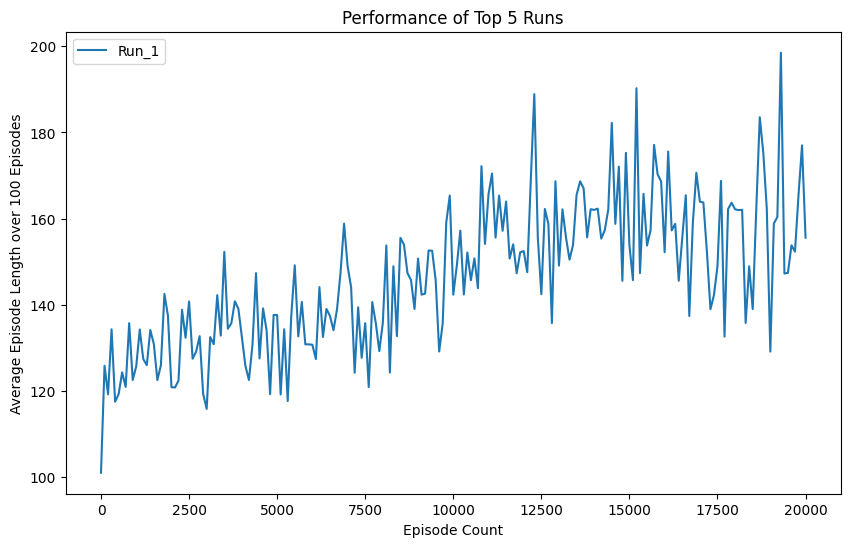

Top Performing Runs:
  alpha    gamma    epsilon    game_board_grid_size    backpropagation_state_buffer_size  Run_ID
-------  -------  ---------  ----------------------  -----------------------------------  --------
  0.001     0.99   0.818722                     100                                   25  Run_1


In [6]:
import pandas as pd
import pickle
from tabulate import tabulate
import matplotlib.pyplot as plt

# Load the data from the pickle file
with open("data/v48-PyTorch-ParamTest-All-Results.pkl", "rb") as f:
    all_results = pickle.load(f)

# Initialize empty lists to store config and metrics data
config_data = []
metrics_data = []

# Iterate through the all_results dictionary to separate config and metrics
for param_id, result in all_results.items():
    config = result['config']
    metrics = result['metrics']
    
    # Add a parameter ID to link config and metrics
    config['param_id'] = param_id
    metrics['param_id'] = param_id
    
    config_data.append(config)
    metrics_data.append(metrics)

# Convert lists of dictionaries to DataFrames
config_df = pd.DataFrame(config_data)
metrics_df = pd.DataFrame(metrics_data)

# Merge the config and metrics DataFrames on 'param_id'
df = pd.merge(config_df, metrics_df, on='param_id')

# Identify and sort the top runs by max average episode length over 100 episodes
df['max_avg_episode_length'] = df['KR_avg_episode_length_every_100_episodes'].apply(lambda x: max(x.values()))
sorted_df = df.sort_values(by='max_avg_episode_length', ascending=False)

# Take the top 5 runs
top_5_runs = sorted_df.head(5)

# Create a new figure for the plot
plt.figure(figsize=(10, 6))

# Initialize lists to store config and metrics for text summary
config_list = []
metrics_list = []

# Loop through the top 5 runs to plot and collect summaries
for index, row in top_5_runs.iterrows():
    # Extract the config and metrics for this run
    config = row[['alpha', 'gamma', 'epsilon', 'game_board_grid_size', 'backpropagation_state_buffer_size']]
    metrics = row['KR_avg_episode_length_every_100_episodes']
    
    # Generate a short identifier for the run
    short_id = f"Run_{index+1}"
    
    # Plotting
    plt.plot(list(metrics.keys()), list(metrics.values()), label=short_id)
    
    # Collect data for Text Summary
    config['Run_ID'] = short_id
    config_list.append(config)
    metrics_list.append({"Run_ID": short_id, "Last_Avg_Ep_Length": list(metrics.values())[-1]})

# Add legend to the plot
plt.legend()
plt.xlabel('Episode Count')
plt.ylabel('Average Episode Length over 100 Episodes')
plt.title("Performance of Top 5 Runs")
plt.show()

# Print out the text summaries
print("Top Performing Runs:")
print(tabulate(config_list, headers="keys"))
#print("Metrics:")
#print(tabulate(metrics_list, headers="keys"))


# Parameter Tuning and Analysis for Reinforcement Learning in Pong

## Refactoring the Code

Initially, the Pong game was implemented in a monolithic script. To make it more modular and facilitate parameter tuning, the following steps were taken:

1. **Encapsulation**: The core game logic was encapsulated into a function called `play_de_game()`.
2. **Parameterization**: The function was designed to accept various hyperparameters as arguments, allowing for easy tuning. These parameters include:
    - `alpha`: The learning rate
    - `gamma`: The discount factor
    - `epsilon`: The exploration rate
    - `epsilon_min`: The minimum exploration rate
    - `epsilon_decay`: The decay rate for `epsilon`
    - `GAME_BOARD_GRID_SIZE`: The size of the game board grid
    - `reward_for_winning_episode`: The reward for winning an episode
    - `punishment_for_losing_episode`: The punishment for losing an episode
    - `reward_for_hitting_ball`: The reward for hitting the ball

## Running the Tests

After refactoring, the game was set up to run over a thousand tests, each with 2500 episodes. The tests were designed to explore a wide range of hyperparameters:

- **Alpha**: Learning rate, affecting how quickly the agent adapts to new information.
- **Gamma**: Discount factor, influencing how much future rewards are considered.
- **Epsilon**: Exploration rate, determining the likelihood of taking a random action.
- **Epsilon Min**: The minimum value that `epsilon` can decay to.
- **Epsilon Decay**: The rate at which `epsilon` decays over time.
- **Game Board Grid Size**: Affects the complexity of the state space.
- **Reward for Winning Episode**: Encourages the agent to win.
- **Punishment for Losing Episode**: Discourages the agent from losing.
- **Reward for Hitting Ball**: Encourages the agent to hit the ball.

The results of each test run were stored in a Python dictionary and then serialized to a pickle file (`all_results.pkl`) for later analysis.

## Data Analysis Plan

### Steps Involved:

1. **Load Data**: Import the `all_results.pkl` file into a Pandas DataFrame.
2. **Data Cleaning**: Remove any missing values and outliers, and convert columns to appropriate data types.
3. **Exploratory Data Analysis (EDA)**: Use statistical and visual methods to understand the data's underlying structure.
4. **Performance Metrics**: Evaluate the performance of different parameter sets based on metrics like average reward, episodes to convergence, etc.

### Expected Insights:

- **Optimal Parameters**: Identify the set of parameters that yield the best performance.
- **Parameter Sensitivity**: Understand how sensitive the model's performance is to changes in individual parameters.
- **Convergence Behavior**: Analyze how quickly the agent learns optimal policies under different parameter settings.
- **Reward Dynamics**: Examine how different reward structures affect the agent's learning process.

By the end of this analysis, I expect to have a comprehensive understanding of how different hyperparameters affect the learning process and performance of the reinforcement learning agent in the Pong game.


# Notes

## Implementing Game Mechanics for Pong

### 1. Initialize Pygame and Create Window
- Initialized Pygame and created an 800x600 window for the game.

### 2. Initialize Paddle and Ball Attributes
- Defined the dimensions of the paddles and the ball. Initialized their starting positions.

### 3. Paddle Movement
- Implemented keyboard controls for moving the paddles up and down.

### 4. Ball Movement and Collision Detection
- Added logic for ball movement and collision detection with the walls and paddles.

### 5. Ball Reset and Scoring
- Implemented ball reset and scoring mechanics. The ball resets to the center after a point is scored.

### 6. Paddle Boundaries
- Added boundaries to prevent the paddles from moving out of the window.

### 7. Game Over Conditions
- Implemented immediate feedback game-over conditions. The game resets after each point, serving as an episode in RL terms.


## Defining RL Elements for Pong

### 1. State Representation
- Decide how to represent the state of the game. Consider the trade-offs between granularity and computational complexity.

### 2. Action Space
- Define the set of actions I can take (e.g., move paddle up, move paddle down, stay still).

### 3. Reward Structure
- Design the rewards I receive for various outcomes (e.g., +1 for scoring, -1 for opponent scoring).

### 4. Policy Initialization
- Initialize my policy, which could be a Q-table, a neural network, or some other function mapping states to actions.

### 5. Learning Algorithm
- Choose and implement a learning algorithm (e.g., Q-learning, SARSA, Deep Q-Networks) to update my policy based on experiences.

### 6. Exploration-Exploitation Strategy
- Decide on a strategy for balancing exploration (trying new actions) and exploitation (sticking with known good actions), such as ε-greedy.

### 7. Training Loop
- Implement the training loop where I interact with the environment, update my policy, and optionally log metrics like average reward over time.

### 8. Evaluation Metrics
- Define metrics to evaluate my performance (e.g., average reward, win rate).

### 9. Hyperparameter Tuning
- Experiment with different learning rates, discount factors, and other hyperparameters to optimize performance.

### 10. Testing and Validation
- Test the trained agent to see how well it performs and validate that it is learning effectively.


## Q-Learning Algorithm

Q-Learning is a model-free reinforcement learning algorithm that aims to learn a policy, which tells an agent what action to take under what circumstances. It defines a function \( Q(s, a) \), representing the quality or the utility of taking action \( a \) in state \( s \).

### Outline

1. **Initialize Q-Table**: Create a table to store the Q-values for each state-action pair.
2. **Policy**: Define how the agent chooses an action (e.g., \(\epsilon\)-greedy).
3. **Learning**: Update the Q-values using the Q-Learning update rule.
4. **Training Loop**: Incorporate these elements into the game loop.

The Q-table will be represented as a Python dictionary. The keys will be the states, and the values will be another dictionary mapping actions to Q-values.


## max() reference

| Iterable Type | What It Returns to `max()` | Example of Using `max()` |
|---------------|----------------------------|--------------------------|
| List          | Individual list elements   | `max([1, 2, 3])` returns `3` |
| Tuple         | Individual tuple elements  | `max((1, 2, 3))` returns `3` |
| String        | Individual characters     | `max("abc")` returns `'c'` |
| Set           | Individual set elements    | `max({1, 2, 3})` returns `3` |
| Dictionary    | Dictionary keys           | `max({'a': 1, 'b': 2}, key=lambda k: k)` returns `'b'` |
|               |                            | `max({'a': 1, 'b': 2}.values())` returns `2` |
|               |                            | `max({'a': 1, 'b': 2}, key=lambda k: {'a': 1, 'b': 2}[k])` returns `'b'` |
| Numpy Array   | Individual array elements  | `import numpy as np; max(np.array([1, 2, 3]))` returns `3` |


## Building intuition around training variables

1. **Alpha (α) - Learning Rate**: 
    - **What it does**: Determines how much of the new Q-value estimate I adopt.
    - **Intuition**: Think of it as a "blending factor." If α is 1, I consider only the most recent information. If α is 0, I learn nothing and stick to my prior knowledge. A value between 0 and 1 blends the old and new information.
    - **Example**: If α is high (closer to 1), I will rapidly adapt to new strategies but may also forget useful past knowledge quickly.

2. **Gamma (γ) - Discount Factor**: 
    - **What it does**: Influences how much future rewards contribute to the Q-value.
    - **Intuition**: It's like a "patience meter." A high γ makes me prioritize long-term reward over short-term reward.
    - **Example**: If γ is close to 1, I will consider future rewards with greater weight, making me more strategic but potentially slower to train.

3. **Epsilon (ε) - Exploration Rate**: 
    - **What it does**: Controls the trade-off between exploration (trying new actions) and exploitation (sticking with known actions).
    - **Intuition**: It's like the "curiosity level." A high ε encourages me to try new things, while a low ε makes me stick to what I know.
    - **Example**: If ε starts high and decays over time (ε-decay), I will initially explore a lot and gradually shift to exploiting my learned knowledge.
